In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import foxes
import foxes.variables as FV

# Data Paths
lidar_path = 'data/measurements/'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_planned_netherlands_path = 'data/turbine-info/coordinates/planned_netherlands/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
shapefiles_DEU_path = 'data/shapefiles/DEU/*'
shapefiles_DNK_path = 'data/shapefiles/DNK/*'
shapefiles_NLD_path = 'data/shapefiles/NLD/*'
turbine_power_curves_path = 'data/turbine-info/power_curves/'

# Function to read and extract data from csv files
def read_csv(path):
    data = pd.read_csv(path)
    return data

In [8]:
# Read the CSV file
data = pd.read_csv('LT_corrected_buoy6.csv', index_col=0)
data.index = pd.to_datetime(data.index)

data_2023 = data[data.index.year == 2023]

data_2023

,long-term_WS150,long-term_WD150
time,,
2023-01-01 00:00:00,21.579621,225.517803
2023-01-01 01:00:00,21.616580,231.363431
2023-01-01 02:00:00,19.990306,231.284592
2023-01-01 03:00:00,19.547231,232.026783
2023-01-01 04:00:00,18.286222,230.613454
...,...,...
2023-12-31 19:00:00,17.698616,179.283877
2023-12-31 20:00:00,17.441924,184.611145
2023-12-31 21:00:00,16.943322,187.576282


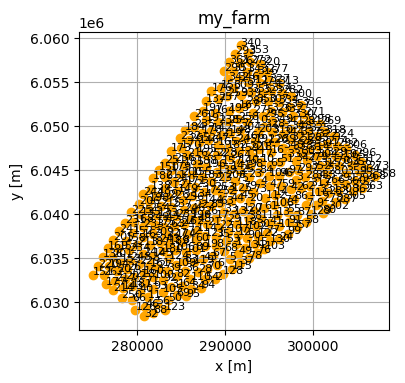

calculating wind farm power for N.9.1-3 Cluster for Wake Model: ['Bastankhah2014_linear']:
[########################################] | 100% Completed | 106.42 ms
[########################################] | 100% Completed | 14m 43s
Efficiency added to farm results


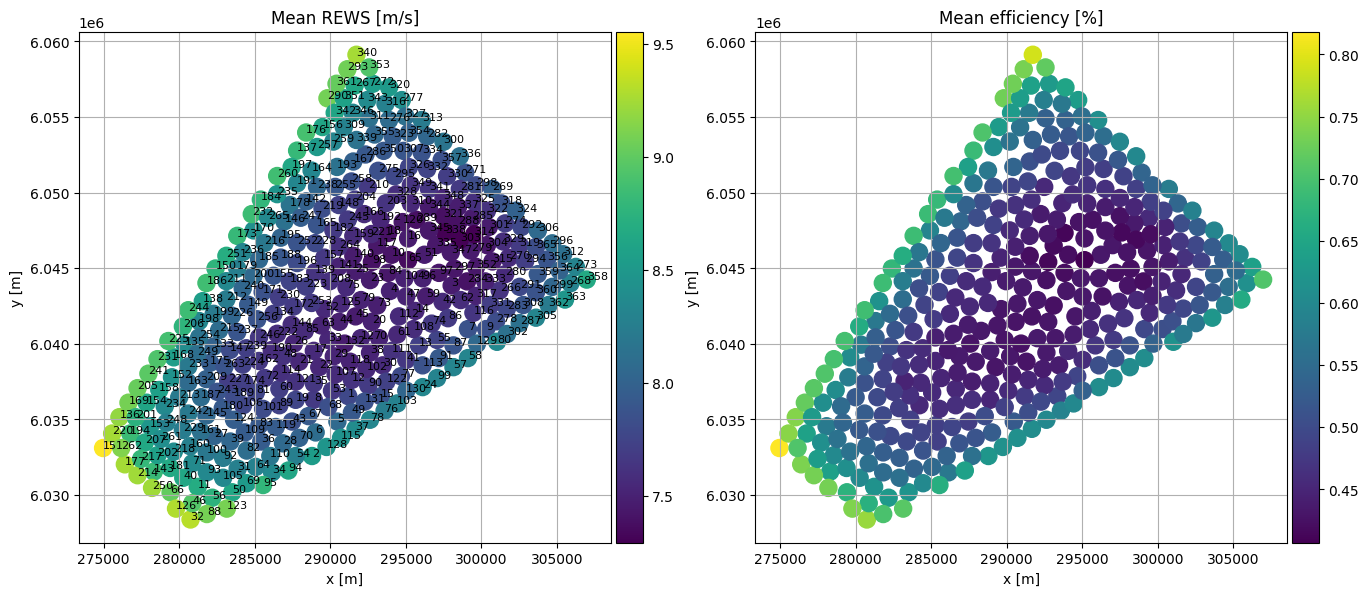


Farm power        : 2252.7 MW
Farm ambient power: 3460.8 MW
Farm efficiency   : 65.09 %
Annual farm yield : 19.73 TWh


,Farm power [MW],Farm ambient power [MW],Farm efficiency [%],Annual farm yield [TWh]
N.9.1-3 Cluster,2252.7,3460.8,65.1,19.7


In [13]:
from Foxes_Farm_Power import Foxes_Farm_Power
###-------------------------------------add Turbine Layouts----------------------------------###
# create 3 Dataframes for Turbine Layouts
current_path =  turbines_area_of_interest_path                           # path .csv's
turb_files = os.listdir(turbines_area_of_interest_path)
# read files in path to dataframe and put's those in list, also pass filename
Turb_dfs = [(read_csv(current_path + file),file) for file in turb_files] 

###-------------------------------------get Turbine Layouts----------------------------------###
# combine previus Turbine_Layouts #Julia: here we use the best calc layout considering wake effects? 
Cluster_Turb_df = pd.concat([Turb_dfs[0][0], Turb_dfs[1][0],Turb_dfs[2][0]], ignore_index=True) 
Cluster_Turb_df = (Cluster_Turb_df, "N.9.1-3 Cluster")


###----------------------------------------Add States-----------------------------------------###
# define States as Foxes object and have a look at the wind rose.
# Wind and other atmospheric inflow conditions are called `States`
States = foxes.input.states.Timeseries(                      # StatesTable for panda df or pd readable file (single height)
    data_source = data_2023 ,                                         # the data
    output_vars = [FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col =     {FV.WS: "long-term_WS150", FV.WD: "long-term_WD150", FV.TI: "time"}, # Mapping from variable names to data column names
    fixed_vars =  {FV.RHO: 1.225, FV.TI: 0.05},                  # TI = Turbulanze Intensity %5 default
    )

###--------------------------------------Important Parameters---------------------------------------###
Parameters = dict(                              # passed to the foxes.algorithms.Downwind()
    TType         = "IEA15MW",                  #"NREL5MW","IEA15MW"
    rotor_model   = "centre",
    wake_models   = ["Bastankhah2014_linear"],
    partial_wakes = None,
    )

###-------------------------------------get Turbine Layouts----------------------------------###
# combine previus Turbine_Layouts #Julia: here we use the best calc layout considering wake effects? 
Cluster_Turb_df = pd.concat([Turb_dfs[0][0], Turb_dfs[1][0],Turb_dfs[2][0]], ignore_index=True) 
Cluster_Turb_df = (Cluster_Turb_df, "N.9.1-3 Cluster")

###--------------------------------------compute farm results--------------------------------------###

Result = pd.concat(                                             # add's new output df to Results Dataframe
    [                                                    # the previous results we add to 
    Foxes_Farm_Power(Cluster_Turb_df,States,Parameters)         # run the function
    ], ignore_index=False)                                      # keep the name we passed
Result.style.format(precision=1)
 
###--------------------------------------Save Farm Results into a csv --------------------------------------###


In [15]:
Result.to_csv(f'farm_result_of_N9_cluster_frams.csv')

In [16]:
Result

,Farm power [MW],Farm ambient power [MW],Farm efficiency [%],Annual farm yield [TWh]
N.9.1-3 Cluster,2252.667583,3460.826877,65.090444,19.733368


In [ ]:
# Paths
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
external_farms_path = 'data/turbine-info/coordinates/existing_planned/'

# Read internal turbine layout files
internal_files = os.listdir(turbines_area_of_interest_path)
Turb_dfs = [(pd.read_csv(turbines_area_of_interest_path + file), file) for file in internal_files]
Cluster_Turb_df = pd.concat([Turb_dfs[0][0], Turb_dfs[1][0], Turb_dfs[2][0]], ignore_index=True)
Cluster_Turb_df = (Cluster_Turb_df, "N.9.1-3 Cluster")

# Read external turbine layout files
external_files = os.listdir(external_farms_path)
external_dfs = [pd.read_csv(external_farms_path + file) for file in external_files]
external_combined_df = pd.concat(external_dfs, ignore_index=True)

# Combine internal and external layouts for wake effect calculation
combined_df = pd.concat([Cluster_Turb_df[0], external_combined_df], ignore_index=True)
Combined_Turb_df = (combined_df, "Combined_Cluster")

# Define States using a valid data source
data_source_path = 'data/turbine-info/coordinates/wind_rose_bremen.csv'  # Update with an actual valid data file path
States = foxes.input.states.Timeseries(
    data_source=data_2023,
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "long-term_WS150", FV.WD: "long-term_WD150", FV.TI: "time"},
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.05},
)

# Define Parameters
Parameters = {
    'TType': "IEA15MW",
    'rotor_model': "centre",
    'wake_models': ["Bastankhah2014_linear"],
    'partial_wakes': None,
}

# Calculate the farm results with wake effects
combined_results = Foxes_Farm_Power(Combined_Turb_df, States, Parameters)

# Extract the results for the farm of interest (Cluster_Turb_df)
farm_of_interest_coords = Cluster_Turb_df[0][['x', 'y']]  # Adjust column names as necessary

# Filter the results for the farm of interest
def filter_farm_of_interest(combined_results, farm_of_interest_coords):
    # Assuming the combined_results have columns 'x' and 'y' for turbine coordinates
    interest_results = combined_results.merge(farm_of_interest_coords, on=['x', 'y'], how='inner')
    return interest_results

# Filtered results for the farm of interest
interest_results = filter_farm_of_interest(combined_results, farm_of_interest_coords)

# Save the farm of interest results into a CSV file
interest_results.to_csv(f'farm_of_interest_results.csv', index=False)

print("Results for the farm of interest considering external wake effects have been calculated and saved.")
